# GIS Visualization of Building Footprint
This notebook shows how to use C# and Python to visualize a building on a map.
Make sure the model has a survey coordinate system defined with real world coordinates.

Installation of Jupyter is required. See [here](https://github.com/dotnet/interactive/blob/main/docs/jupyter-in-polyglot-notebooks.md) for options.

Run below command to connect to a Python-kernel:

In [1]:
#!connect jupyter --kernel-name pythonkernel --kernel-spec python3

The `#!connect jupyter` feature is in preview. Please report any feedback or issues at https://github.com/dotnet/interactive/issues/new/choose.

Kernel added: #!pythonkernel

Once connected, we setup connection to a revit interactive kernel. Run below:

In [2]:
#r "nuget:RevitInteractive"

Installed Packages RevitInteractive, 0.1.0

Loading extensions from `C:\Users\sejsau\.nuget\packages\revitinteractive\0.1.0\interactive-extensions\dotnet\Jowsy.DotNet.Interactive.Extensions.dll`

Revit C# Kernel Added.

In [3]:
#!connect revit --kernel-name revit --revit-version 2024

Kernel added: #!revit

In [ ]:
#r "nuget:Revit.RevitApi.x64, 2023.0.0"
#r "nuget:Revit.RevitApiUi.x64, 2023.0.0"
using Autodesk.Revit.DB;
using Autodesk.Revit.UI;

  2 standard systems of units exists: the international one (SI), also known as the metric system, and the imperial system.
  Internally, Revit stores in the imperial system.

In [5]:
#!revit
// Assume 'doc' is the current Revit Document you are working with
Units units = doc.GetUnits();
// Get the FormatOptions for a specific UnitType (e.g., Length)
FormatOptions lengthFormatOptions = units.GetFormatOptions(SpecTypeId.Length);

// Get the ForgeTypeId for the Length unit
ForgeTypeId lengthUnitTypeId = lengthFormatOptions.GetUnitTypeId();

// Output the ForgeTypeId to the console or use it as needed
lengthUnitTypeId

## Shared Coordinates

The project location defines the offset from the site location in 3 directions. It mesasures in decimal feet.

For each location there are two basepoints: project base boint and survey point.


In [6]:
#!revit
var projectBasePoint = new FilteredElementCollector(doc).OfClass(typeof(BasePoint))
                                                  .Cast<BasePoint>()
                                                  .Where(x => x.IsShared!)
                                                  .First();

var surveyPoint = new FilteredElementCollector(doc).OfClass(typeof(BasePoint))
                                                  .Cast<BasePoint>()
                                                  .Where(x => x.IsShared)
                                                  .First();


string prompt1 = "Displays survey and base point in the active ProjectLocation:\n";
prompt1 +=  "\n\t" + $"Survey point:{surveyPoint.SharedPosition}";
prompt1 +=  "\n\t" + $"Project base point:{projectBasePoint.SharedPosition}";
display(prompt1);


string prompt2 = "Displays survey and base point in internal coordinate system:\n";
prompt2 += "\n\t" +  $"Survey point:{surveyPoint.Position}";
prompt2 += "\n\t" + $"Project base point:{projectBasePoint.Position}";
display(prompt2);

ProjectLocation projectLocation = doc.ActiveProjectLocation;

ProjectPosition projectPosition = projectLocation.GetProjectPosition(new XYZ(0,0,0));

projectPosition

Displays survey and base point in the active ProjectLocation:

	Survey point:(1370149.563103074, 258246.564048711, -12.000000000)
	Project base point:(1370149.563103074, 258246.564048711, -12.000000000)

Displays survey and base point in internal coordinate system:

	Survey point:(-2.625450704, -0.289981233, -792.500000000)
	Project base point:(-2.625450704, -0.289981233, -792.500000000)

In [7]:

#!revit

var convertToDisplayUnits = (double valueInFeet) => UnitUtils.ConvertFromInternalUnits(valueInFeet, lengthUnitTypeId);

// Format the prompt string to show the message.
String prompt = "Current project location information converted to display units:\n";
prompt += "\n\t" + "Origin point position:";
prompt += "\n\t\t" + "Angle: " + projectPosition.Angle;
prompt += "\n\t\t" + "East to West offset: " + convertToDisplayUnits(projectPosition.EastWest); //The offset of the project location from the site location in the east/west direction. Measured in decimal feet.
prompt += "\n\t\t" + "Elevation: " + convertToDisplayUnits(projectPosition.Elevation);
prompt += "\n\t\t" + "North to South offset: " + convertToDisplayUnits(projectPosition.NorthSouth);
display(prompt);


XYZ translationVector = new XYZ(
  projectPosition.EastWest,
  projectPosition.NorthSouth,
  projectPosition.Elevation);

Transform translationTransform
  = Transform.CreateTranslation(
    translationVector);

// Create a rotation for the angle about true north

Transform rotationTransform
  = Transform.CreateRotationAtPoint(XYZ.BasisZ, projectPosition.Angle, XYZ.Zero);
// Combine the transforms 

Transform finalTransform
  = translationTransform.Multiply(
    rotationTransform);

var internalToSurveyTransform = finalTransform;


display(internalToSurveyTransform.OfPoint(new XYZ(0,0,0)));
// Use the inverse of the survey point transform to convert the point from internal to survey coordinates
internalToSurveyTransform

Current project location information converted to display units:

	Origin point position:
		Angle: 0,454057035353887
		East to West offset: 1370151,79533991
		Elevation: 780,5
		North to South offset: 258247,9762099

Z,780.5
Y,258247.9762099
X,1370151.79533991


In [8]:
#!revit


var floorsInActiveView = new FilteredElementCollector(doc, doc.ActiveView.Id)
                .WhereElementIsNotElementType()
                .WhereElementIsViewIndependent()
                .OfClass(typeof(Floor))
                .OfType<Floor>();


/*
var allFloors = new FilteredElementCollector(doc)
                .WhereElementIsNotElementType()
                .WhereElementIsViewIndependent()
                .OfClass(typeof(Floor))
                .OfType<Floor>();


var floorsNotInActiveView = allFloors.Where(f => !floorsInActiveView.Any(x => x.Id.IntegerValue == f.Id.IntegerValue));
*/


//display($"Floors not in active view: {floorsNotInActiveView.Count()}");
//display(floorsNotInActiveView.First().Id);

List<Solid> solids = new List<Solid>();
foreach (var floor in floorsInActiveView){

    GeometryElement geometry = floor.get_Geometry(new Options());

    foreach(var g in geometry){

        Solid solid = g as Solid;

        if (solid != null){
            solids.Add(solid);
        }

    }

}
display(solids.Count());
solids
                

31

In [9]:
#!revit

List<PlanarFace> planarFaces = new List<PlanarFace>();
foreach (var solid in solids){

PlanarFace lowest = null;
    FaceArray faceArray = solid.Faces;
    foreach( Face f in faceArray )
    {
      PlanarFace pf = f as PlanarFace;
      if( null != pf && (pf.FaceNormal.Z==1.0 || pf.FaceNormal.Z==-1.0))
      {
        if( ( null == lowest )
          || ( pf.Origin.Z < lowest.Origin.Z ) )
        {
          lowest = pf;
        }
      }
    }
planarFaces.Add(lowest);

}
planarFaces

In [10]:
#!revit

var convertToDisplayUnits = (XYZ pt) => new XYZ(UnitUtils.ConvertFromInternalUnits(pt.X, lengthUnitTypeId),
                                                UnitUtils.ConvertFromInternalUnits(pt.Y, lengthUnitTypeId),
                                                UnitUtils.ConvertFromInternalUnits(pt.Z, lengthUnitTypeId));

List<List<XYZ>> polygons = new List<List<XYZ>>();

display(planarFaces.Count());

foreach (PlanarFace f in planarFaces){
//display(f.EdgeLoops);
    if (f!=null){
    var loops = f.EdgeLoops;
    foreach (EdgeArray loop in loops)
        {
            // Select many flattens the list of lists of points into a single list of points
            List<XYZ> vertices = loop.Cast<Edge>()
                .SelectMany(e => e.Tessellate(), (e, point) => convertToDisplayUnits(internalToSurveyTransform.OfPoint(point)) )
                .ToList();

            // Remove last point if it's a duplicate of the first (closed loop assumption)
            if (vertices.First().IsAlmostEqualTo(vertices.Last()))
            {
                vertices.RemoveAt(vertices.Count - 1);
            }

            polygons.Add(vertices);
        }
    }
}

polygons


31

In [11]:
#!set --value @revit:polygons --name polygons

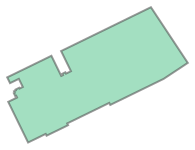

In [13]:
import shapely
from shapely.geometry import Point, Polygon, LineString, GeometryCollection
from shapely.ops import unary_union
import numpy as np

coords = list(map(lambda p: list(map(lambda pt: (pt["X"],pt["Y"]),p) ),polygons))

_polygons = list(map(lambda coords: Polygon(coords),coords))
_sorted = sorted(_polygons, key=lambda p: p.area, reverse=True)
footprint = _sorted[0]

footPrintGeojson = shapely.to_geojson(footprint)
footprint

In [ ]:
import geopandas as gpd
from shapely.geometry import Point, Polygon
from fiona.crs import from_epsg

# Create an empty geopandas GeoDataFrame
newdata = gpd.GeoDataFrame()

# Insert the polygon into 'geometry' -column at index 0
newdata.loc[0, 'geometry'] = footprint

# Set the GeoDataFrame's coordinate system to WGS84 (i.e. epsg code 4326)
# https://spatialreference.org/ref/epsg/2272/
//newdata.crs = from_epsg(3007)
newdata.crs = from_epsg(2272) #Revit 2024 Snowdon Towers CS

# Determine the output path for the Shapefile
outfp = "footprint.shp"

# Write the data into that Shapefile
newdata.to_file(outfp)

In [ ]:
#r "nuget: FSharp.Data, 6.3.0"
#r "nuget: Plotly.NET, 4.2.0"
#r "nuget: Plotly.NET.Interactive, 4.2.0"

In [ ]:
open Plotly.NET
open Plotly.NET.LayoutObjects

// a simple Mapbox with a OpenStreetMap base layer.
let mb = Mapbox.init (Style = StyleParam.MapboxStyle.OpenStreetMap)

let baseLayerOnly =
    Chart.PointMapbox(lonlat = []) // deliberately empty chart to show the base map only
    |> Chart.withMapbox mb // add the mapBox
    |> Chart.PointGeo(geojson)


baseLayerOnly